# 2- Compare PX4 flight data 

### A. Local position XY

Compare two `.ulog` files and overlay mission setpoints from a CSV.

In [33]:
!pip install pyulog

Defaulting to user installation because normal site-packages is not writeable


In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib.patches import Circle

try:
    from pyulog import ULog
except ImportError:
    raise ImportError("Install pyulog: pip install pyulog")


def load_local_position_xy(ulog_path: str):
    """Load vehicle_local_position x, y from a PX4 .ulog. Returns (timestamps_us, x, y)."""
    ulog = ULog(ulog_path, ["vehicle_local_position"])
    for d in ulog.data_list:
        if "vehicle_local_position" in d.name or d.name == "vehicle_local_position":
            ts = np.array(d.data["timestamp"], dtype=np.float64)
            x = np.array(d.data["x"], dtype=np.float64)
            y = np.array(d.data["y"], dtype=np.float64)
            if "xy_valid" in d.data:
                valid = np.asarray(d.data["xy_valid"], dtype=bool)
                ts, x, y = ts[valid], x[valid], y[valid]
            return ts, x, y
    raise KeyError(f"vehicle_local_position not found in {ulog_path}")


def load_mission_setpoints(csv_path: str):
    """Load x_local, y_local from mission setpoint CSV. Returns (x, y)."""
    df = pd.read_csv(csv_path)
    if "x_local" in df.columns and "y_local" in df.columns:
        return df["x_local"].values, df["y_local"].values
    if "x" in df.columns and "y" in df.columns:
        return df["x"].values, df["y"].values
    raise KeyError(f"Expected columns x_local,y_local or x,y in {csv_path}")


def load_ground_truth_trees(ground_truth_trees):
    """Return (x, y) arrays. Argument: list of (x,y) tuples in ENU meters, or None."""
    if ground_truth_trees is None:
        return None, None
    if isinstance(ground_truth_trees, (list, tuple)) and len(ground_truth_trees) == 0:
        return None, None
    arr = np.array(ground_truth_trees)
    return arr[:, 0], arr[:, 1]


def apply_rotation_xy(x, y, angle_deg, origin_x=0.0, origin_y=0.0):
    """Rotate (x, y) by angle_deg (0–360) around (origin_x, origin_y). Returns (x_rot, y_rot)."""
    if angle_deg == 0:
        return x.copy(), y.copy()
    rad = np.deg2rad(angle_deg)
    c, s = np.cos(rad), np.sin(rad)
    x_ = x - origin_x
    y_ = y - origin_y
    x_rot = c * x_ - s * y_ + origin_x
    y_rot = s * x_ + c * y_ + origin_y
    return x_rot, y_rot


def apply_flip_xy(x, y, flip_x=False, flip_y=False):
    """Optionally reflect x → -x and/or y → -y. Returns (x, y)."""
    if flip_x:
        x = -x
    if flip_y:
        y = -y
    return x, y

### KLK site

In [35]:
# Paths to the two .ulog files and mission setpoint CSV
ulog_path_1 = "../px4_related/flight_logs/klk/AutonomousMission.ulg"
ulog_path_2 = "../px4_related/flight_logs/klk/ManualPilot.ulg"
mission_csv = "../src/virtual_module/map_processor/maps/klk/triple_id_26_41_54.csv"  # or None to skip

# Rotation in degrees (0–360) per ulog: [ulog_path_1, ulog_path_2]. 90 ≈ NED→ENU; 0 = no rotation.
rotation_deg = [90.0, 90.0]
# Flip after rotation: [ulog_1, ulog_2]. flip_x = reflect left/right (x→-x); flip_y = reflect up/down (y→-y).
flip_x = [True, True]
flip_y = [False, False]

# Ground truth tree positions (red dots). (x - east, y - north)
# Obtained from 2D LiDAR scan
ground_truth_trees = [
    (0.19, -4.55),
    (7.30, 0.53),
    (14.43, 5.54),
]

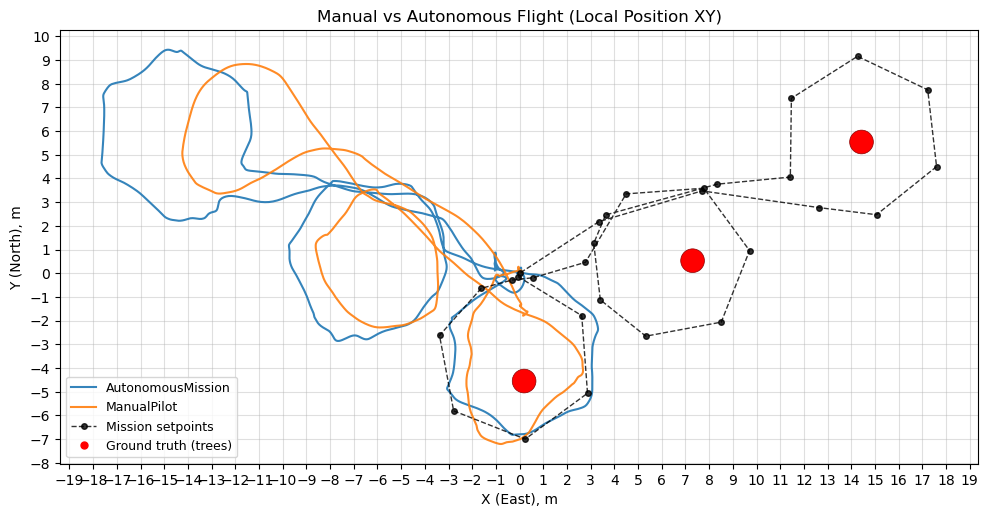

In [36]:
# Overlay plot: both flights + mission setpoints
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_aspect("equal")
colors = plt.cm.tab10.colors

for i, path in enumerate([ulog_path_1, ulog_path_2]):
    ts, x, y = load_local_position_xy(path)
    if rotation_deg[i] != 0:
        x, y = apply_rotation_xy(x, y, rotation_deg[i])
    x, y = apply_flip_xy(x, y, flip_x[i], flip_y[i])
    label = Path(path).stem
    ax.plot(x, y, "-", color=colors[i % len(colors)], label=label, linewidth=1.5, alpha=0.9)

if mission_csv:
    mx, my = load_mission_setpoints(mission_csv)  # already ENU (X=East, Y=North)
    ax.plot(mx, my, "k--", marker="o", markersize=4, label="Mission setpoints", linewidth=1, alpha=0.8)

# Ground truth tree positions: red circles with fixed 1 m diameter
gtx, gty = load_ground_truth_trees(ground_truth_trees)
if gtx is not None:
    for xi, yi in zip(gtx, gty):
        ax.add_patch(Circle((xi, yi), 0.5, color="red", zorder=5, ec="darkred", linewidth=0.5))

# Grid: each cell = 1 m
from matplotlib.ticker import MultipleLocator
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))

# X = East, Y = North (ENU)
if any(r != 0 for r in rotation_deg):
    ax.set_xlabel("X (East), m")
    ax.set_ylabel("Y (North), m")
else:
    ax.set_xlabel("X (North, NED), m")
    ax.set_ylabel("Y (East, NED), m")
# Legend: use small red dot for ground truth (plot uses 1 m diameter circles)
from matplotlib.lines import Line2D
handles, labels = ax.get_legend_handles_labels()
if gtx is not None:
    handles.append(Line2D([0], [0], linestyle="none", marker="o", color="red", markersize=5, label="Ground truth (trees)"))
    labels.append("Ground truth (trees)")
ax.legend(handles, labels, loc="best", fontsize=9)
ax.grid(True, which="major", alpha=0.4)
ax.set_title("Manual vs Autonomous Flight (Local Position XY)")
plt.tight_layout()
plt.show()

In [37]:
# Paths to the two .ulog files and mission setpoint CSV
ulog_path_1 = "../px4_related/flight_logs/zenxin/AutonomousMission.ulg"
ulog_path_2 = "../px4_related/flight_logs/zenxin/ManualPilot.ulg"
mission_csv = "../src/virtual_module/map_processor/maps/zenxin/mosti_triple.csv"  # or None to skip

# Rotation in degrees (0–360) per ulog: [ulog_path_1, ulog_path_2]. 90 ≈ NED→ENU; 0 = no rotation.
rotation_deg = [90.0, 90.0]
# Flip after rotation: [ulog_1, ulog_2]. flip_x = reflect left/right (x→-x); flip_y = reflect up/down (y→-y).
flip_x = [False, False]
flip_y = [False, False]

# Ground truth tree positions (red dots). (x - east, y - north)
# Obtained from 2D LiDAR scan
ground_truth_trees = [
    (4.27, 0.05),
    (-0.90, 7.06),
    (-4.98, -0.95)
]

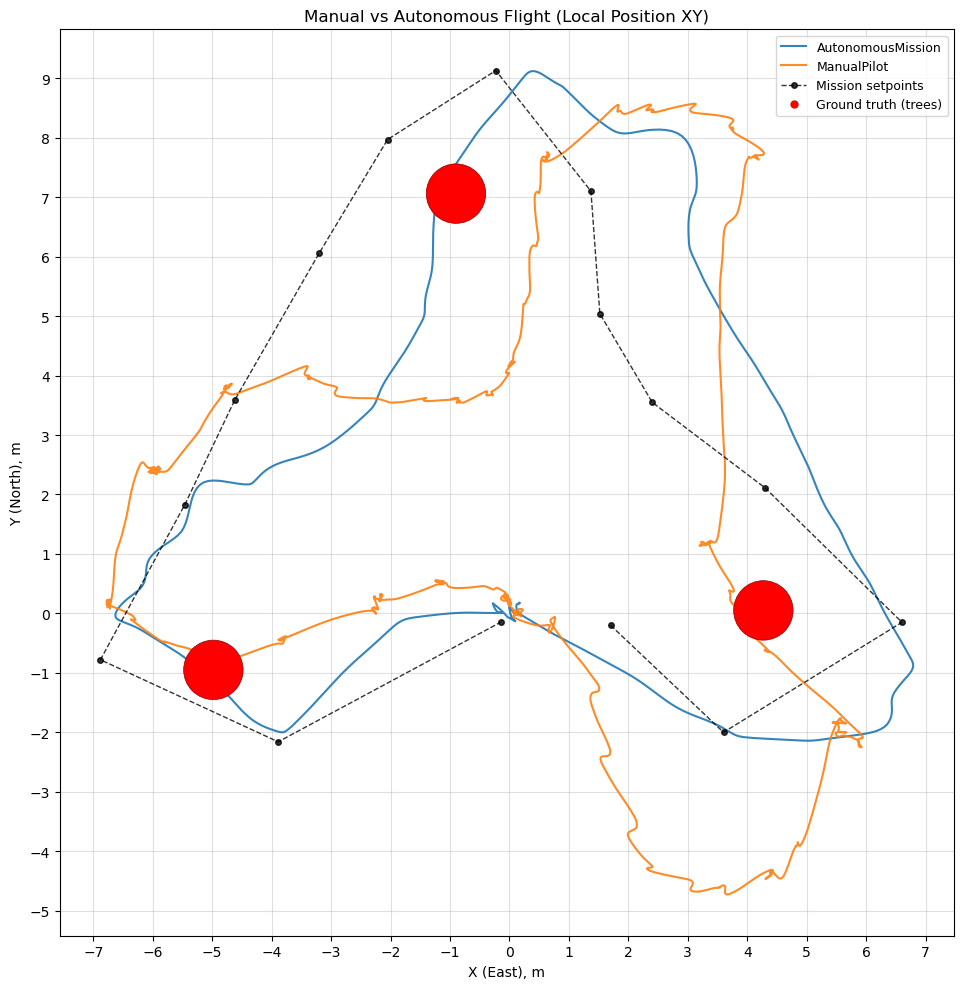

In [38]:
# Overlay plot: both flights + mission setpoints
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_aspect("equal")
colors = plt.cm.tab10.colors

for i, path in enumerate([ulog_path_1, ulog_path_2]):
    ts, x, y = load_local_position_xy(path)
    if rotation_deg[i] != 0:
        x, y = apply_rotation_xy(x, y, rotation_deg[i])
    x, y = apply_flip_xy(x, y, flip_x[i], flip_y[i])
    label = Path(path).stem
    ax.plot(x, y, "-", color=colors[i % len(colors)], label=label, linewidth=1.5, alpha=0.9)

if mission_csv:
    mx, my = load_mission_setpoints(mission_csv)  # already ENU (X=East, Y=North)
    ax.plot(mx, my, "k--", marker="o", markersize=4, label="Mission setpoints", linewidth=1, alpha=0.8)

# Ground truth tree positions: red circles with fixed 1 m diameter
gtx, gty = load_ground_truth_trees(ground_truth_trees)
if gtx is not None:
    for xi, yi in zip(gtx, gty):
        ax.add_patch(Circle((xi, yi), 0.5, color="red", zorder=5, ec="darkred", linewidth=0.5))

# Grid: each cell = 1 m
from matplotlib.ticker import MultipleLocator
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))

# X = East, Y = North (ENU)
if any(r != 0 for r in rotation_deg):
    ax.set_xlabel("X (East), m")
    ax.set_ylabel("Y (North), m")
else:
    ax.set_xlabel("X (North, NED), m")
    ax.set_ylabel("Y (East, NED), m")
# Legend: use small red dot for ground truth (plot uses 1 m diameter circles)
from matplotlib.lines import Line2D
handles, labels = ax.get_legend_handles_labels()
if gtx is not None:
    handles.append(Line2D([0], [0], linestyle="none", marker="o", color="red", markersize=5, label="Ground truth (trees)"))
    labels.append("Ground truth (trees)")
ax.legend(handles, labels, loc="best", fontsize=9)
ax.grid(True, which="major", alpha=0.4)
ax.set_title("Manual vs Autonomous Flight (Local Position XY)")
plt.tight_layout()
plt.show()